(N. B. Add extension import call and calls to show() and play() as desired once that's working.)

# rhythmmakertools as a first example of top-down score control

In [1]:
import abjad
%load_ext abjadext.ipython
import abjadext.rmakers
rmakers = abjadext.rmakers

For this demo, we need to import two existing modules: `presentation.py` gives us some convenient typesetting overrides -- it hides the barlines and measure numbers -- and more legibible spacing -- it turns on proportional spacing -- for complex rhythms. `demo.py` gives us a preview function that shows us where we're headed at the end of the demo.

In [2]:
component = abjad.Score(
    [abjad.Staff(
        [abjad.Voice(r"c'4 d e f \break c d e f g f a a f a f a f a f a")]
    )]
)

In [3]:
import demo
import presentation

abjad.select().tuplets()[:-1].map(expression=abjad.select().note(-1))
abjad.select().tuplets()[:-1].map(expression=abjad.select().note(-1))
abjad.select().tuplets()[:-1].map(expression=abjad.select().note(-1))
abjad.select().tuplets()[:-1].map(expression=abjad.select().note(-1))
abjad.select().tuplets()[:-1].map(expression=abjad.select().note(-1))
abjad.select().tuplets()[:-1].map(expression=abjad.select().note(-1))
abjad.select().tuplets()[:-1].map(expression=abjad.select().note(-1))
abjad.select().tuplets()[:-1].map(expression=abjad.select().note(-1))
abjad.select().tuplets()[:-1].map(expression=abjad.select().note(-1))
abjad.select().tuplets()[:-1].map(expression=abjad.select().note(-1))
abjad.select().tuplets()[:-1].map(expression=abjad.select().note(-1))
abjad.select().tuplets()[:-1].map(expression=abjad.select().note(-1))


Now that we've imported demo.py, we can run a preview function to see where we're headed in this demo: at the end, we'll have generated a complicated polyphonic rhythmic texture using generators that know about some pattern information:

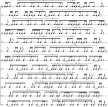

In [4]:
demo.show_demo()

But how do we get to the above output? Let's start from the beginning.

You can build from notational elements in an aggregative way (working "bottom-up") in Abjad, but you can also create generator classes that will output leaves based on pattern information (a "top-down" way of working). Trevor's rhythmmakertools module is one example of this way of working, and we'll look at it in this demo.

# example 1

First, we need to understand the relationship between the two concepts: divisions and selections. Divisions are arbitrary timespans that our rhythm maker converts into durated leaves ("selections") in various ways. To see this, we'll look at the simplest kind of rhythmmaker, a NoteRhythmMaker, which creates a tiechain of durated leaves that add up to a corresponding division:

In [5]:
#abjadext.rmakers is implicit: rmakers = abjadext.rmakers
note_rhythm_maker = rmakers.stack(rmakers.note(),)

We configure the NoteRhythmMaker by passing it some divisions (a list of arbitrary durations), and the NoteRhythmMaker returns selections (tied groups of durated leaves) that correspond to each division:

In [6]:
divisions = [(3, 8), (5, 4), (1, 4), (13, 16)]

In [7]:
selections = note_rhythm_maker(divisions)

In [8]:
for s in selections:
    print(s)

c'4.
c'1
c'4
c'4
c'2.
c'16


Note the relationship between durations and selections here. While some divisions yield single-symbol selections ((3,8) yields a dotted quarter note and (1,4) a quarter note), some divisions yield tiechains of multiple symbols ((5,4) yields a whole note tied to a quarter note). This solves a fundamental problem of common practice notation: we can represent 1-8 of anything with a single symbol, but 5 of anything must be represented by two symbols. The "selection" abstraction allows us to address the symbolic corrollary of a division as single object in the system.

And of course, now that we have our selections as leaves, we can render these via LilyPond by putting them in a Container and showing the container:

In [9]:
staff = abjad.Staff(selections, lilypond_type='RhythmicStaff')

In [10]:
abjad.show(staff)

But this output looks horrible, because our durations don't fit neatly into LilyPond's defaults of mensural notation in common time. In many notation programs, we would be out of luck: we would be forced to think metrically. But in Abjad, we can override LilyPond's defaults and think freely about rhythms, without meter:

In [11]:
import presentation

Now we have a helper function, `make_sketch`, that will apply appropriate overrides to a LilyPond file and show the result: 

In [12]:
sketch = presentation.make_sketch(selections, divisions)

In [13]:
abjad.show(sketch)

Note that we're now viewing unmetered rhythms in proportional notation and can work freely with rhythm, without any requirement to address meter.

Rhythm makers are reconfigurable. Just pass in a different set of divisions for the corresponding selections:

In [14]:
divisions_b = [(5, 16), (3, 8), (3, 8), (5, 8), (1, 4)]

In [15]:
sketch = presentation.make_sketch(selections, divisions_b)

In [16]:
abjad.show(sketch)

And of course anything you can do in Python, you can do to the supplied divisions...

In [17]:
divisions_b *= 20

In [18]:
selections = note_rhythm_maker(divisions_b)

In [19]:
sketch = presentation.make_sketch(selections, divisions_b)

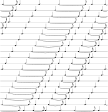

In [20]:
abjad.show(sketch)

...including anything that requires code in another module:

In [21]:
import random

In [22]:
random_numerators = [random.randrange(1, 16 + 1) for x in range(100)]

In [23]:
random_divisions = [(x, 32) for x in random_numerators]

In [24]:
selections = note_rhythm_maker(random_divisions)

In [25]:
sketch = presentation.make_sketch(selections, random_divisions)

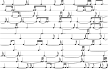

In [26]:
abjad.show(sketch)


# example 2

In this example, we'll model Medieval isorhythmic practice, as can be found in the music of composers like Machaut and Ockeghem. In this technique of composition, a cycle of durations, a Talea, produces a cyclic pattern of rhythmic durations. We'll still pass in a list of divisions, as we did in example 1, but this time they'll control the durations of beamed groups.

In [27]:
my_talea = rmakers.talea(
    [1, 2, 3], # counts
    16, # denominator
    )

In [28]:
talea_rhythm_maker = rmakers.stack(
    my_talea, rmakers.beam(), rmakers.extract_trivial(),
)

You can see that the Talea creates a cycle of durations:

for i in range(20):
   print(i, my_talea[i])

Next, we give this Talea to a stack:

In [29]:
talea_rhythm_maker = rmakers.stack(
    my_talea,
    rmakers.beam(), 
    rmakers.extract_trivial(),
)

Remember what our divisions are?:

In [30]:
divisions

[(3, 8), (5, 4), (1, 4), (13, 16)]

In [31]:
selections = talea_rhythm_maker(divisions)

In [32]:
sketch = presentation.make_sketch(selections, divisions)

In [33]:
abjad.show(sketch)

Note that the beaming corresponds to our divisions. Note also that when the duration in the Talea's cycle crosses between beamed groups, we tie across beamed groups by default.

We can refine the output with additional specifiers:

**Tie across divisions**

A tie specifier allows us to always tie between beamed groups:

In [34]:
selector = abjad.select().tuplets()[:-1]
selector = selector.map(abjad.select().note(-1))

talea_rhythm_maker = rmakers.stack(
    my_talea, 
    rmakers.beam(), 
    rmakers.extract_trivial(),
    rmakers.tie(selector), # Ties across divisions.
)


**Extra counts**

extra counts cyclically inflect tempo by adding more equally spaced events to our divisions.
We need to specify it in our talea:

In [35]:
my_talea = rmakers.talea(
    [1, 2, 3], # counts
    16, # denominator
    extra_counts=[0, 1, 1]
    )

**Silences first and last logical ties**

~~And a burnish specifier cyclically replaces n counts from the left of each division with the corresponding class, i.e., if we have a class list of [Rest] and a count list of [1,0], we would replace the left-most leaf of the first division with a Rest, do nothing to the following division, replace the left-most leaf of the third division, etc.~~

To do so, we need to add some lines in our stack:

Let's see all three of these specifiers work together by configuring our rhythm maker with them:

In [36]:
selector = abjad.select().tuplets()[:-1]
selector = selector.map(abjad.select().note(-1))

talea_rhythm_maker = rmakers.stack(
    my_talea, 
    rmakers.force_rest(abjad.select().logical_ties().get([0, -1]),),# Silences first and last logical ties.
    rmakers.beam(), 
    rmakers.extract_trivial(),
    rmakers.rewrite_meter(),
    rmakers.tie(selector), # Ties across divisions.
)


Remember our divisions:

And pass in our divisions to return selections:

In [37]:
selections = talea_rhythm_maker(divisions)

In [38]:
sketch = presentation.make_sketch(selections, divisions)

In [39]:
abjad.show(sketch)
divisions

[(3, 8), (5, 4), (1, 4), (13, 16)]

Note the effect of all three specifiers: the output ties across all beamed groups (tie specifier), the second and third divisions have an extra equally spaced sixteenth note in their spans, resulting in new tuplets (extra counts), and every other division has its left-most leaf replaced by a rest (burnish specifier).

# example 3

Finally, we can use the above in a loop to rapidly prototype polyphonic textures.

In [40]:
score = abjad.Score()

We can rotate items to have different voices:

In [41]:
def rotate(l, n):
    return l[-n:] + l[:-n]

In [42]:
divisions

[(3, 8), (5, 4), (1, 4), (13, 16)]

In [43]:
divisions = rotate(divisions, 1)
divisions


[(13, 16), (3, 8), (5, 4), (1, 4)]

In [47]:
score = abjad.Score()
counts = [1, 2, 3]
selector = abjad.select().tuplets()[:-1]
selector = selector.map(abjad.select().note(-1))

for i in range(12):
    
    my_talea = rmakers.talea(
    counts, # counts
    16, # denominator
    extra_counts=[0, 1, 1]
    )
    
    voice = abjad.Voice()
    
    talea_rhythm_maker = rmakers.stack(
            my_talea, 
            rmakers.force_rest(abjad.select().logical_ties().get([0, -1]),),# Silences first and last logical ties.
            #rmakers.tie(selector), # Ties across divisions.
            rmakers.beam(), 
            rmakers.extract_trivial(),
            rmakers.rewrite_meter(), 
            )
    selections = talea_rhythm_maker(divisions)
    voice.append(selections)
    
    staff = abjad.Staff(lilypond_type='RhythmicStaff', name=str(i))
    staff.append(voice)
    score.append(staff)
    divisions = rotate(divisions, 1)
    counts = rotate(counts, 1)

In [45]:
sketch = presentation.make_sketch_lilypond_file(score)

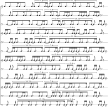

In [46]:
abjad.show(sketch)

Note that we vary the texture here through two pattern rotations: first, we rotate the talea by 1 for each staff, cycling [1,2,3...], [3,1,2...], [2,3,1...] per staff; also, we rotate the list of divisions by one each staff, which changes the way that the selections are beamed.

# conclusion

This is just one example of a set of classes that generate rhythms in a top-down way. Because Abjad extends Python, you can use any of the object-oriented programming capabilities of the Python language to create your own similar maker classes, according to your own musical ideas.